<a href="https://colab.research.google.com/github/MarcioB1999/Aprendizado_de_Maquina/blob/main/Classifica%C3%A7%C3%A3o_Drug.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Importação Bibliotecas**

In [ ]:
!pip install pyod

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 134 kB 5.2 MB/s 
  Created wheel for pyod: filename=pyod-1.0.4-py3-none-any.whl size=165073 sha256=3bfefc6aae34e3d6e5ee8e9372d84f6ea8c017817c9b72a89a9b5ae1b564415c
  Stored in directory: /root/.cache/pip/wheels/3d/48/a8/87d61660791c7e6b0f5c3068da7fb17ade7fdc041e864fe053
Successfully built pyod


In [ ]:
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from yellowbrick.classifier import ConfusionMatrix
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier as rn
from sklearn.model_selection import cross_val_score, KFold
from matplotlib import pyplot as plt
from pyod.models.knn import KNN
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
import numpy as np
from scipy.stats import shapiro
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
import pickle

# **Importação dos Dados**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/arquivos/drug200.csv')
df.head()

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,DrugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,DrugY


# **Algumas Informações**

In [ ]:
columns = list(df.columns[1:4])+[df.columns[5]]

print('valores únicos por variável categórica')
for i in columns:
    print(f'{i}----->{df[i].unique()}')

valores únicos por variável categórica
Sex----->['F' 'M']
BP----->['HIGH' 'LOW' 'NORMAL']
Cholesterol----->['HIGH' 'NORMAL']
Drug----->['DrugY' 'drugC' 'drugX' 'drugA' 'drugB']


In [ ]:
print('valores faltantes')
df.isnull().sum()

valores faltantes


Age            0
Sex            0
BP             0
Cholesterol    0
Na_to_K        0
Drug           0
dtype: int64

# **Tratamento de Dados Categóricos**

In [ ]:
onehotencoder_census = ColumnTransformer(transformers=[('OneHot', OneHotEncoder(), [1,2,3])], remainder='passthrough')
df = pd.DataFrame(onehotencoder_census.fit_transform(df),columns=[f'{i}' for i in range(7)]+['Age','Na_to_K','Drug'])

label_encoder_drug = LabelEncoder()
df['Drug'] = label_encoder_drug.fit_transform(df['Drug'])

df.head()

,0,1,2,3,4,5,6,Age,Na_to_K,Drug
0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,23,25.355,0
1,0.0,1.0,0.0,1.0,0.0,1.0,0.0,47,13.093,3
2,0.0,1.0,0.0,1.0,0.0,1.0,0.0,47,10.114,3
3,1.0,0.0,0.0,0.0,1.0,1.0,0.0,28,7.798,4
4,1.0,0.0,0.0,1.0,0.0,1.0,0.0,61,18.043,0


# **Tratamento de Outliers**

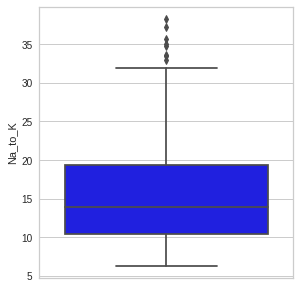

In [ ]:
fig=plt.figure(figsize=(10,5))

ax = fig.add_subplot(1,2,1)
sns.boxplot(y=df['Na_to_K'],color='blue')

In [ ]:
detector = KNN()
detector.fit(df.iloc[:,[7,8]])

KNN(algorithm='auto', contamination=0.1, leaf_size=30, method='largest',
  metric='minkowski', metric_params=None, n_jobs=1, n_neighbors=5, p=2,
  radius=1.0)

In [ ]:
previsoes = detector.labels_


In [ ]:
outliers_index = []
for i in range(len(previsoes)):

  if previsoes[i] == 1:
    outliers_index.append(i)

outliers = df.loc[outliers_index,:]
df_aux = df.copy()
df_aux['bool'] = np.zeros(len(df))
df_aux.loc[outliers_index,'bool']=1
df_aux['bool'].replace({0:'Normal',1:'Outlier'},inplace=True)
df_aux.head(5)

,0,1,2,3,4,5,6,Age,Na_to_K,Drug,bool
0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,23,25.355,0,Normal
1,0.0,1.0,0.0,1.0,0.0,1.0,0.0,47,13.093,3,Normal
2,0.0,1.0,0.0,1.0,0.0,1.0,0.0,47,10.114,3,Normal
3,1.0,0.0,0.0,0.0,1.0,1.0,0.0,28,7.798,4,Normal
4,1.0,0.0,0.0,1.0,0.0,1.0,0.0,61,18.043,0,Normal


Text(0.5, 0, 'Age')

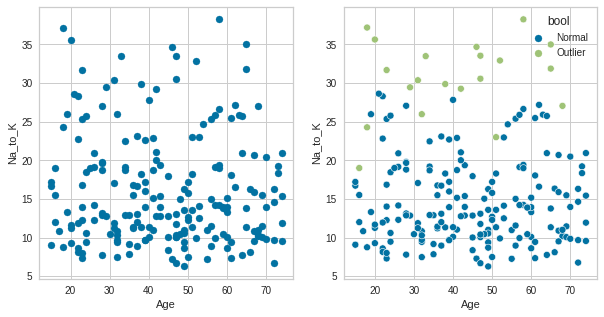

In [ ]:
fig=plt.figure(figsize=(10,5))



ax = fig.add_subplot(1,2,1)
plt.scatter(df.Age,df.Na_to_K)

plt.ylabel('Na_to_K')
plt.xlabel('Age')



ax = fig.add_subplot(1,2,2)
sns.scatterplot(data=df_aux,x='Age',y='Na_to_K',hue='bool')

plt.ylabel('Na_to_K')
plt.xlabel('Age')



In [ ]:
df.loc[outliers_index,['Age','Na_to_K']] = np.nan

In [ ]:
imputer = KNNImputer(n_neighbors=15, weights='uniform', metric='nan_euclidean')
imputer.fit(df)


df = pd.DataFrame(imputer.transform(df),columns=df.columns)
df.head()

,0,1,2,3,4,5,6,Age,Na_to_K,Drug
0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,23.0,25.355,0.0
1,0.0,1.0,0.0,1.0,0.0,1.0,0.0,47.0,13.093,3.0
2,0.0,1.0,0.0,1.0,0.0,1.0,0.0,47.0,10.114,3.0
3,1.0,0.0,0.0,0.0,1.0,1.0,0.0,28.0,7.798,4.0
4,1.0,0.0,0.0,1.0,0.0,1.0,0.0,61.0,18.043,0.0


Text(0.5, 0, 'Age')

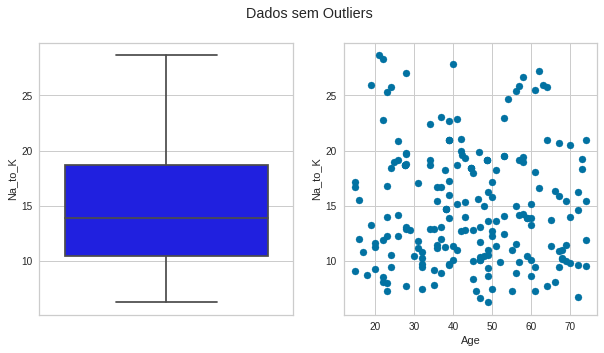

In [ ]:
fig=plt.figure(figsize=(10,5))
fig.suptitle('Dados sem Outliers')


ax = fig.add_subplot(1,2,1)
sns.boxplot(y=df['Na_to_K'],color='blue')

ax = fig.add_subplot(1,2,2)
plt.scatter(df.Age,df.Na_to_K)
plt.ylabel('Na_to_K')
plt.xlabel('Age')

# **Aplicação da Padronização e PCA**

In [ ]:
pca = PCA(0.9)
x_columns = list(df.columns[0:9])
x = df[x_columns]


x = pd.DataFrame(StandardScaler().fit_transform(x))


x_pca = pca.fit_transform(x)
x_pca = pd.DataFrame(x_pca)
y = df['Drug']
x_pca.head()

,0,1,2,3,4
0,0.630913,2.186790,-1.479902,-1.476920,1.664700
1,-1.916832,-0.815356,0.979515,-1.090072,0.163591
2,-1.974664,-0.896342,0.980833,-0.917771,-0.220048
3,-0.741564,2.228431,0.094329,1.707478,-0.253277
4,-0.621348,1.544373,1.655684,-1.670043,-0.462872


# **Pegando Melhores Parâmetros para Cada Modelo**
SVM, Random Forest, Rede Neural

## **redes neurais**

In [ ]:
parametros = {'activation': ['relu', 'logistic', 'tahn'],
              'solver': ['adam', 'sgd'],
              'batch_size': [10, 56]}

In [ ]:
grid_search = GridSearchCV(estimator=rn(), param_grid=parametros)
grid_search.fit(x_pca, y)
melhores_parametros_RN = grid_search.best_params_

In [ ]:
print(melhores_parametros_RN)

{'activation': 'relu', 'batch_size': 10, 'solver': 'adam'}


## **SVM**

In [1]:
parametros = {'tol': [0.001, 0.0001, 0.00001],
              'C': [1.0, 1.5, 2.0],
              'kernel': ['rbf', 'linear', 'poly', 'sigmoid']}

In [ ]:
grid_search = GridSearchCV(estimator=SVC(), param_grid=parametros)
grid_search.fit(x_pca, y)
melhores_parametros_SVM = grid_search.best_params_


In [ ]:
print(melhores_parametros_SVM)

##**Random Forest**

In [ ]:
parametros = {'criterion': ['gini', 'entropy'],
              'n_estimators': [10, 40, 100, 150],
              'min_samples_split': [2, 5, 10],
              'min_samples_leaf': [1, 5, 10]}

In [ ]:
grid_search = GridSearchCV(estimator=RandomForestClassifier(), param_grid=parametros)
grid_search.fit(x_pca, y)
melhores_parametros_RF = grid_search.best_params_


In [ ]:
print(melhores_parametros_RF)

{'criterion': 'entropy', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}


# **Comparação de Modelos**
SVM, Random Forest, Rede Neural

In [ ]:
resultados_rede_neural = []
resultados_random_forest = []
resultados_svm = []


for i in range(60):

    kfold = KFold(n_splits=10, shuffle=True, random_state=i)


    random_forest = RandomForestClassifier(
              criterion = melhores_parametros_RF['criterion'],
              n_estimators = melhores_parametros_RF['n_estimators'],
              min_samples_split = melhores_parametros_RF['min_samples_split'],
              min_samples_leaf = melhores_parametros_RF['min_samples_leaf']
              )
    scores = cross_val_score(random_forest, x_pca, y, cv = kfold)
    resultados_random_forest.append(scores.mean())


    svm = SVC(
            tol = melhores_parametros_SVM['tol'],
            C = melhores_parametros_SVM['C'],
            kernel = melhores_parametros_SVM['kernel']
            )
    scores = cross_val_score(svm, x_pca, y, cv = kfold)
    resultados_svm.append(scores.mean())


    rede_neural = rn(
              activation = melhores_parametros_RN['activation'],
              solver = melhores_parametros_RN['solver'],
              batch_size = melhores_parametros_RN['batch_size']
               )
    scores = cross_val_score(rede_neural, x_pca, y, cv = kfold)
    resultados_rede_neural.append(scores.mean())


In [ ]:
resultados = pd.DataFrame({'Random forest': resultados_random_forest,
                           'SVM': resultados_svm,
                           'Rede neural': resultados_rede_neural})
resultados.head(5)

,Random forest,SVM,Rede neural
0,0.875,0.770,0.930
1,0.855,0.775,0.915
2,0.885,0.775,0.945
3,0.860,0.795,0.915
4,0.860,0.785,0.920


In [ ]:
resultados.describe()

,Random forest,SVM,Rede neural
count,60.000000,60.000000,60.000000
mean,0.870250,0.789667,0.926000
std,0.012737,0.012851,0.010325
min,0.830000,0.755000,0.895000
25%,0.860000,0.780000,0.920000
50%,0.870000,0.790000,0.925000
75%,0.880000,0.800000,0.930000
max,0.895000,0.815000,0.950000


In [ ]:
print('Coeficiente de Variação')
(resultados.std() / resultados.mean()) * 100

Coeficiente de Variação


Random forest    1.463573
SVM              1.627361
Rede neural      1.115035
dtype: float64

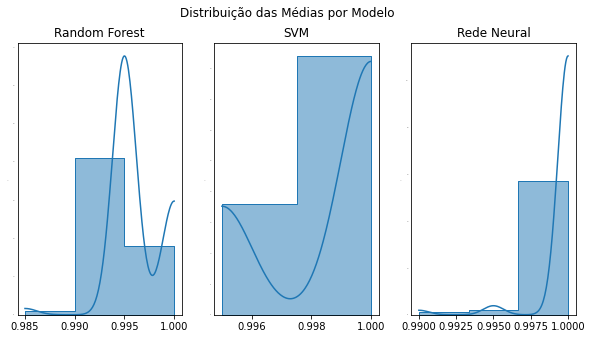

In [ ]:
fig=plt.figure(figsize=(10,5))
fig.suptitle('Distribuição das Médias por Modelo')


ax = fig.add_subplot(1,3,1)
ax.set_title('Random Forest')
sns.histplot(resultados_random_forest, bins=len(pd.Series(resultados_random_forest).unique()), kde=True, element='step')
plt.ylabel([], fontsize=0)
plt.tick_params(axis='y', labelsize=0, length=0)

ax = fig.add_subplot(1,3,2)
ax.set_title('SVM')
sns.histplot(resultados_svm, bins=len(pd.Series(resultados_svm).unique()), kde=True, element='step')
plt.ylabel([], fontsize=0)
plt.tick_params(axis='y', labelsize=0, length=0)

ax = fig.add_subplot(1,3,3)
ax.set_title('Rede Neural')
sns.histplot(resultados_rede_neural, bins=len(pd.Series(resultados_rede_neural).unique()), kde=True, element='step')
plt.ylabel([], fontsize=0)
plt.tick_params(axis='y', labelsize=0, length=0)

In [ ]:
alpha=0.05

In [ ]:
p={}
_,p['Random Forest'] = shapiro(resultados_random_forest)
_,p['SVM'] = shapiro(resultados_svm)
_,p['Rede Neural'] = shapiro(resultados_rede_neural)
for i in p:
    if p[i] <= alpha:
        print(f'Média amostral de {i} não segue uma normal')
    else:
        print(f'Média amostral de {i} segue uma normal')

Média amostral de Random Forest não segue uma normal
Média amostral de SVM não segue uma normal
Média amostral de Rede Neural não segue uma normal


In [ ]:
classificador_rede_neural = rn(
              activation = melhores_parametros_RN['activation'],
              solver = melhores_parametros_RN['solver'],
              batch_size = melhores_parametros_RN['batch_size']
              )
classificador_rede_neural.fit(x_pca, y)



classificador_svm = SVC(
            tol = melhores_parametros_SVM['tol'],
            C = melhores_parametros_SVM['C'],
            kernel = melhores_parametros_SVM['kernel']
            )
classificador_svm.fit(x_pca, y)



classificador_random_forest = RandomForestClassifier(
              criterion = melhores_parametros_RF['criterion'],
              n_estimators = melhores_parametros_RF['n_estimators'],
              min_samples_split = melhores_parametros_RF['min_samples_split'],
              min_samples_leaf = melhores_parametros_RF['min_samples_leaf']
              )

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


# **Matriz de confusão**

Text(0.5, 0, 'Valor Predito')

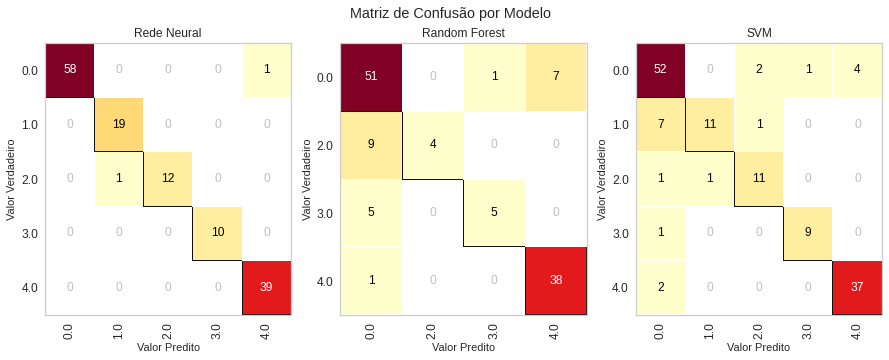

In [ ]:
fig=plt.figure(figsize=(15,5))
fig.suptitle('Matriz de Confusão por Modelo')


ax = fig.add_subplot(1,3,1)
ax.set_title('Rede Neural')
X_train, X_test, y_train, y_test = train_test_split(
        x_pca, y, test_size=0.7, random_state=42
    )
cm=ConfusionMatrix(classificador_rede_neural)
cm.fit(X_train,y_train)
cm.score(X_test,y_test)
plt.ylabel('Valor Verdadeiro')
plt.xlabel('Valor Predito')


ax = fig.add_subplot(1,3,2)
ax.set_title('Random Forest')
X_train, X_test, y_train, y_test = train_test_split(
        x_pca, y, test_size=0.7, random_state=42
    )
cm=ConfusionMatrix(classificador_random_forest)
cm.fit(X_train,y_train)
cm.score(X_test,y_test)
plt.ylabel('Valor Verdadeiro')
plt.xlabel('Valor Predito')


ax = fig.add_subplot(1,3,3)
ax.set_title('SVM')
X_train, X_test, y_train, y_test = train_test_split(
        x_pca, y, test_size=0.7, random_state=42
    )
cm=ConfusionMatrix(classificador_svm)
cm.fit(X_train,y_train)
cm.score(X_test,y_test)
plt.ylabel('Valor Verdadeiro')
plt.xlabel('Valor Predito')

# **Exportando Modelos**

In [ ]:
pickle.dump(classificador_rede_neural, open('rede_neural_finalizado.sav', 'wb'))

pickle.dump(classificador_svm, open('svm_finalizado.sav', 'wb'))

pickle.dump(classificador_random_forest, open('random_forest_finalizado.sav', 'wb'))